In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import pi,sqrt,sin,cos,tan,acos,asin,atan2,radians,degrees


filepath = 'FLIGHT01.TXT'
#df = pd.read_csv(filepath, sep=",")
df = pd.read_csv(filepath, header=None, sep='\n')
df = df[0].str.split(',', expand=True)
df.columns = df.iloc[0] 
df = df.drop(index=0)
columns = list(df.columns)
gps_idx = columns.index('gps_str')
gps_rmc = ['gps_rmc','utc','gps_status','lat','n','lon','w','knots','track_angle','date','magnetic_varx','magnetic_vary','checksum']
new_columns = columns[:gps_idx] + gps_rmc
df = df.iloc[:,:len(new_columns)]
df.columns = new_columns

# crop from start to end
start = 2135#2170
end = 2300
df = df.iloc[start:end]
df

,time_since_start,count,sys,p_stat,p_pres,p_temp,p_psi,p_vel,p_cel,strain0,...,lat,n,lon,w,knots,track_angle,date,magnetic_varx,magnetic_vary,checksum
2136,214285,2135,0,2,8133.0,661.0,0.0054256927,7.815,14.582,169,...,3850.1216,N,07730.3480,W,0.02,84.11,210222,,,D*44
2137,214385,2136,0,2,8139.0,661.0,0.0058326186,8.103,14.582,174,...,3850.1216,N,07730.3480,W,0.02,82.88,210222,,,D*4D
2138,214485,2137,0,2,8136.0,661.0,0.0056291556,7.960,14.582,168,...,3850.1216,N,07730.3480,W,0.02,79.48,210222,,,D*44
2139,214585,2138,0,2,8136.0,661.0,0.0056291556,7.960,14.582,168,...,3850.1216,N,07730.3480,W,0.02,85.25,210222,,,D*46
2140,214685,2139,0,2,8136.0,662.0,0.0056291556,7.960,14.680,173,...,3850.1216,N,07730.3480,W,0.01,82.86,210222,,,D*4A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2296,230311,2295,3,2,8127.0,660.0,0.0050187668,7.516,14.485,174,...,3850.1091,N,07730.3979,W,6.01,225.02,210222,,,D*7B
2297,230411,2296,3,2,8133.0,660.0,0.0054256927,7.815,14.485,177,...,3850.1092,N,07730.3976,W,5.61,224.85,210222,,,D*73
2298,230511,2297,3,0,8139.0,660.0,0.0058326186,8.103,14.485,174,...,3850.1092,N,07730.3973,W,5.42,224.84,210222,,,D*77
2299,230611,2298,3,0,8133.0,660.0,0.0054256927,7.815,14.485,171,...,3850.1092,N,07730.3971,W,5.25,224.83,210222,,,D*75


In [ ]:
import plotly.graph_objects as go

## converts float from degree-minute-second to degree, latitude conversion
def dd_lat(x):
    degrees = int(float(x)) // 100
    minutes = float(x) - 100*degrees
    return degrees + minutes/60

## converts float from degree-minute-second to degree, longitude conversion
def dd_lon(x):
    return -dd_lat(x)

lats = df['lat'].apply(dd_lat, 1)
lons = df['lon'].apply(dd_lon, 1)

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = lons,
    lat = lats,
    marker = {'size': 8}))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'style': "stamen-terrain",
        'center': {'lon': lons.median(), 'lat': lats.median()},
        'zoom': 18})

In [ ]:
def ms2mph(ms):
    return 2.236936*float(ms)

def haversine(row):
    lat1 = float(row['prev_lat'])
    long1 = float(row['prev_lon'])
    lat2 = float(row['lat'])
    long2 = float(row['lon'])
    degree_to_rad = float(pi / 180.0)
    d_lat = (lat2 - lat1) * degree_to_rad
    d_long = (long2 - long1) * degree_to_rad
    a = pow(sin(d_lat / 2), 2) + cos(lat1 * degree_to_rad) * cos(lat2 * degree_to_rad) * pow(sin(d_long / 2), 2)
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    mi = 3956 * c
    return mi

# input a row from dataframe
# returns the speed using distance/time
def speed(row):
    millis = int(row['time_since_start']) - int(row['prev_time_since_start'])
    hours = millis / 36000
    return row['delta'] / hours

df['prev_lat'] = df['lat'].shift(1)
df['prev_lon'] = df['lon'].shift(1)
df['prev_time_since_start'] = df['time_since_start'].shift(1)
# deletes first row
df.dropna(inplace=True)
# delta distance
df['delta'] = df.apply(lambda row: haversine(row), axis=1)
# add mph column
df['mph'] = df.apply(lambda row: speed(row), axis=1)

#pitot = df['p_vel'].apply(ms2mph, 1)
#ax.plot(x,pitot)

# about 30.34 inhg barametric pressure 
#https://www.localconditions.com/weather-centreville-virginia/20120/charts.php
seaLevel = 1027.4303214666768

def m2ft(m):
    return 3.28084*float(m)

#hpa to m
def pres2alt(hpa):
    atmospheric = float(hpa) / 100.0;
    return 44330.0 * (1.0 - pow(atmospheric / seaLevel, 0.1903));

#df_alt = df['bmp_alt'].astype(float) - float(df.iloc[0]['bmp_alt'])


df_alt = df['bmp_pres'].apply(pres2alt,1).apply(m2ft,1)
df_alt = df_alt-df_alt.iloc[0]
alt = df_alt.apply(m2ft, 1)



#fig, ax = plt.subplots(figsize=(8,6))
#ax.plot(x,alt)
#ax.set_xlabel("seconds")
#ax.set_ylabel("feet")
#ax.set_title("altitude vs time")
#ax.legend(['gps speed','calculated'])




#y = df['mph'].astype(float)
#plt.figure(figsize=(8,10))
#ax.plot(x,y)
#ax.set_xlabel("seconds")
#ax.set_ylabel("mph")
#ax.set_title("mph vs time")
#ax.legend(['groundspeed','calculated'])
#ax.legend(['groundspeed', 'altitude'])

max speed: 46.905752039999996 mph
initial speed: 0.41428043999999997 mph
take off speed: 27.98694528 mph
max speed: 41.658199800000006 mph


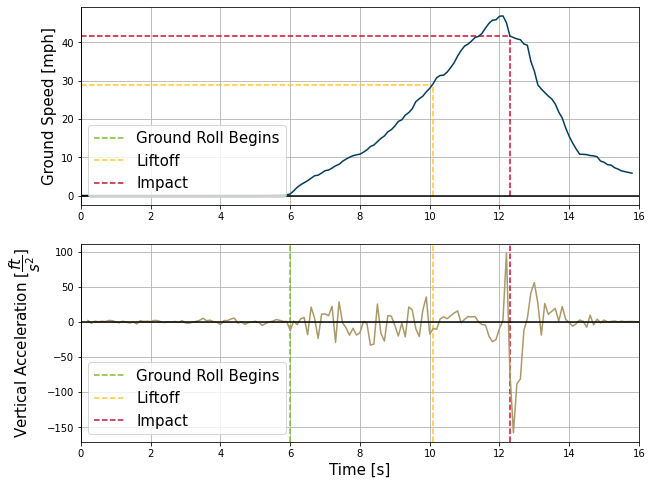

In [ ]:
import matplotlib as mpl


def knots2mph(knots):
    return 1.150779*float(knots)



fig, axs = plt.subplots(2,1,figsize=(10,8))
x = (df.index-start)/10

knots = df['knots'].apply(knots2mph, 1)
#knots = knots.shift(-7)
axs[0].set_xlim(0, 16)
axs[1].set_xlim(0, 16)

# vertical
axs[0].plot([6.0, 6.0], [0, 0], linestyle='dashed', color='#78BE20')
axs[0].plot([10.1, 10.1], [0, 29], linestyle='dashed', color='#FFC72C')
axs[0].plot([12.3, 12.3], [0, 41.6], linestyle='dashed', color='#C9102F')


axs[1].axvline(x=6.0, color='#78BE20', linestyle='--')
axs[1].axvline(x=10.1, color='#FFC72C', linestyle='--')
axs[1].axvline(x=12.3, color='#C9102F', linestyle='--')

#horizontal
axs[0].plot([0, 6.0], [0, 0], linestyle='dashed', color='#78BE20')
axs[0].plot([0, 10.1], [29, 29], linestyle='dashed', color='#FFC72C')
axs[0].plot([0, 12.3], [41.6, 41.6], linestyle='dashed', color='#C9102F')


axs[0].plot(x-0.7,knots,color='#033C5A')


linz = df['lin_z'].astype(float).apply(m2ft,1)
axs[1].plot(x, linz, color='#AA9868')



print("max speed: {} mph".format(str(max(knots))))

def idx2time(i):
    return int((i+0.7)*10) + start

print("initial speed: {} mph".format(str(knots2mph(df.loc[idx2time(6.0)]['knots']))))
print("take off speed: {} mph".format(str(knots2mph(df.loc[idx2time(10.1)]['knots']))))
print("max speed: {} mph".format(str(knots2mph(df.loc[idx2time(12.3)]['knots']))))


mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15) 
axs[0].axhline(y=0, color='k')
axs[0].axvline(x=0, color='k')
axs[1].axhline(y=0, color='k')
axs[1].axvline(x=0, color='k')
axs[1].set_xlabel('Time [s]', fontsize=15)
axs[0].set_ylabel('Ground Speed [mph]', fontsize=15)
axs[1].set_ylabel('Vertical Acceleration [$\dfrac{ft}{s^2}$]', fontsize=15)

axs[1].grid();
axs[0].grid();


axs[0].legend(['Ground Roll Begins','Liftoff','Impact'], loc='lower left', fontsize=15)
axs[1].legend(['Ground Roll Begins','Liftoff','Impact'], loc='lower left', fontsize=15)

fig.savefig('output/groundspeed.png', dpi=300);


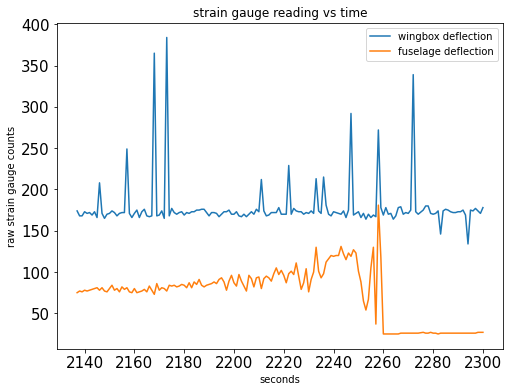

In [ ]:
# strain gauges

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df.index,df['strain0'].astype(float))
ax.plot(df.index,df['strain1'].astype(float))
ax.set_xlabel("seconds")
ax.set_ylabel("raw strain gauge counts")
ax.set_title("strain gauge reading vs time")
ax.legend(['wingbox deflection','fuselage deflection'])

Text(0.5, 1.0, 'altitude vs time')

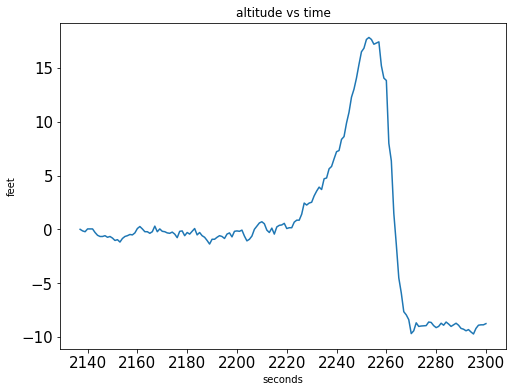

In [ ]:
# about 30.34 inhg barametric pressure 
#https://www.localconditions.com/weather-centreville-virginia/20120/charts.php
seaLevel = 1027.4303214666768

def m2ft(m):
    return 3.28084*float(m)

#hpa to m
def pres2alt(hpa):
    atmospheric = float(hpa) / 100.0;
    return 44330.0 * (1.0 - pow(atmospheric / seaLevel, 0.1903));

#df_alt = df['bmp_alt'].astype(float) - float(df.iloc[0]['bmp_alt'])
df_alt = df['bmp_pres'].apply(pres2alt,1).apply(m2ft,1)
df_alt = df_alt-df_alt.iloc[0]
alt = df_alt.apply(m2ft, 1)



fig, ax = plt.subplots(figsize=(8,6))
ax.plot(df.index,alt)
ax.set_xlabel("seconds")
ax.set_ylabel("feet")
ax.set_title("altitude vs time")
#ax.legend(['gps speed','calculated'])


In [ ]:
df.index

Int64Index([2137, 2138, 2139, 2140, 2141, 2142, 2143, 2144, 2145, 2146,
            ...
            2291, 2292, 2293, 2294, 2295, 2296, 2297, 2298, 2299, 2300],
           dtype='int64', length=163)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

filepath = 'FLIGHT01.TXT'
#df = pd.read_csv(filepath, sep=",")
df = pd.read_csv(filepath, header=None, sep='\n')
df = df[0].str.split(',', expand=True)
df.columns = df.iloc[0] 
df = df.drop(index=0)

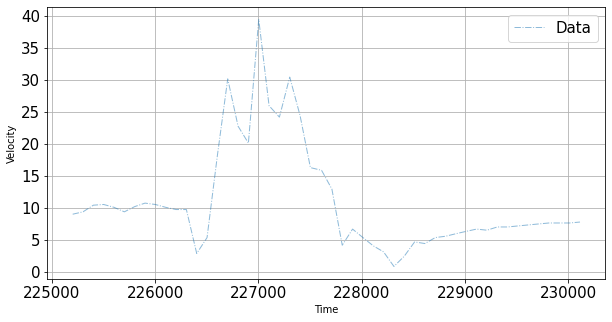

In [ ]:
fname = 'FLIGHT01.TXT'
time_since_start, p_vel = np.loadtxt(fname, delimiter=',', skiprows=5, unpack=True, usecols=(0, 7))

start = 2240
end = 2290

time_since_start = time_since_start[start:end]
p_vel = p_vel[start:end]

plt.figure(figsize=(10, 5))

plt.plot(time_since_start, p_vel, linestyle='-.', linewidth=1, alpha=0.5, label='Data')

plt.xlabel('Time')
plt.ylabel('Velocity')
plt.legend(loc='best', fontsize=15)
plt.grid();


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=5505152a-0b2f-4f1a-b46f-59a354116aef' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>